In [1]:
# Import necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [3]:
# Load in the data

df = pd.read_csv('Spotify_Christmas_Streams.csv')

In [5]:
# Clean datetimes

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [7]:
# Define Christmas Market Size

christmas_market = (
    df[df['week_of_year'] >= 46]
    .groupby('year')['streams']
    .sum()
    .reset_index(name='total_christmas_streams')
)

In [9]:
# Trend Forward

christmas_market['growth_rate'] = (
    christmas_market['total_christmas_streams']
    .pct_change()
)

avg_growth = christmas_market['growth_rate'].mean()

market_2026 = (
    christmas_market.iloc[-1]['total_christmas_streams']
    * (1 + avg_growth)
)

In [11]:
# Baseline Market Share

market_share = (
    df[df['week_of_year'] >= 46]
    .groupby(['year', 'track'])['streams']
    .sum()
    .reset_index()
)

market_share = market_share.merge(
    christmas_market[['year', 'total_christmas_streams']],
    on='year'
)

market_share['share'] = (
    market_share['streams'] /
    market_share['total_christmas_streams']
)

In [13]:
# Average share of the markey by track

avg_share = (
    market_share
    .groupby('track')['share']
    .mean()
    .reset_index()
)

In [15]:
# Slider effect of new song on the market share

# moves from 1%-25% ~ 5% brackets
scenario_shares = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25]

In [17]:
# Scenario Simulation Function

def simulate_new_hit(
    avg_share_df,
    total_market,
    new_song_share,
    new_song_name="🎄 New Breakout Hit"
):
    adjusted = avg_share_df.copy()
    adjusted['adjusted_share'] = (
        adjusted['share'] * (1 - new_song_share)
    )

    new_song = pd.DataFrame({
        'track': [new_song_name],
        'adjusted_share': [new_song_share]
    })

    ecosystem = pd.concat([
        adjusted[['track', 'adjusted_share']],
        new_song
    ])

    ecosystem['projected_streams'] = (
        ecosystem['adjusted_share'] * total_market
    )

    return ecosystem.sort_values(
        'projected_streams',
        ascending=False
    )

In [19]:
# Run all Scenarios at once
scenario_results = {}

for share in scenario_shares:
    scenario_results[f"{int(share*100)}%"] = simulate_new_hit(
        avg_share,
        market_2026,
        share
    )

C:\Users\rfull\AppData\Local\Temp\ipykernel_23524\1692565394.py:26: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


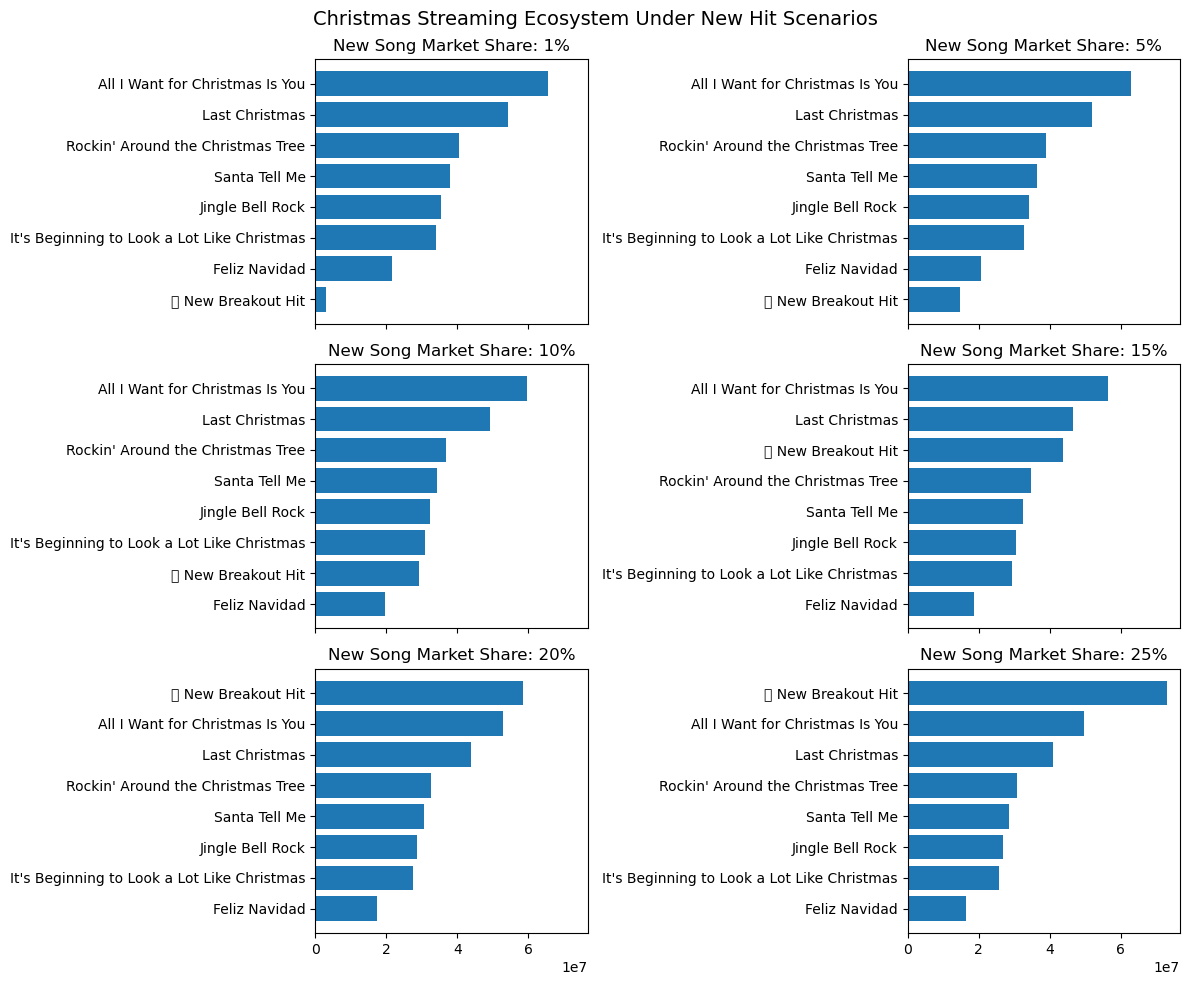

In [21]:
# Visualized impact

fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 10),
    sharex=True
)

axes = axes.flatten()

for ax, (label, df_scenario) in zip(axes, scenario_results.items()):
    top10 = df_scenario.head(10)

    ax.barh(
        top10['track'][::-1],
        top10['projected_streams'][::-1]
    )

    ax.set_title(f"New Song Market Share: {label}")

plt.suptitle(
    "Christmas Streaming Ecosystem Under New Hit Scenarios",
    fontsize=14
)
plt.tight_layout()
plt.show()

In [23]:
# Summary Table

summary = []

for label, df_scenario in scenario_results.items():
    rank = (
        df_scenario
        .reset_index(drop=True)
        .index[
            df_scenario['track'] == '🎄 New Breakout Hit'
        ][0] + 1
    )

    summary.append({
        'New Song Share': label,
        'Rank Among Christmas Songs': rank,
        'Projected Streams': int(
            df_scenario
            .loc[df_scenario['track'] == '🎄 New Breakout Hit',
                 'projected_streams']
            .values[0]
        )
    })

summary_df = pd.DataFrame(summary)
summary_df


,New Song Share,Rank Among Christmas Songs,Projected Streams
0,1%,8,2919796
1,5%,8,14598983
2,10%,7,29197967
3,15%,3,43796951
4,20%,1,58395935
5,25%,1,72994919
